In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

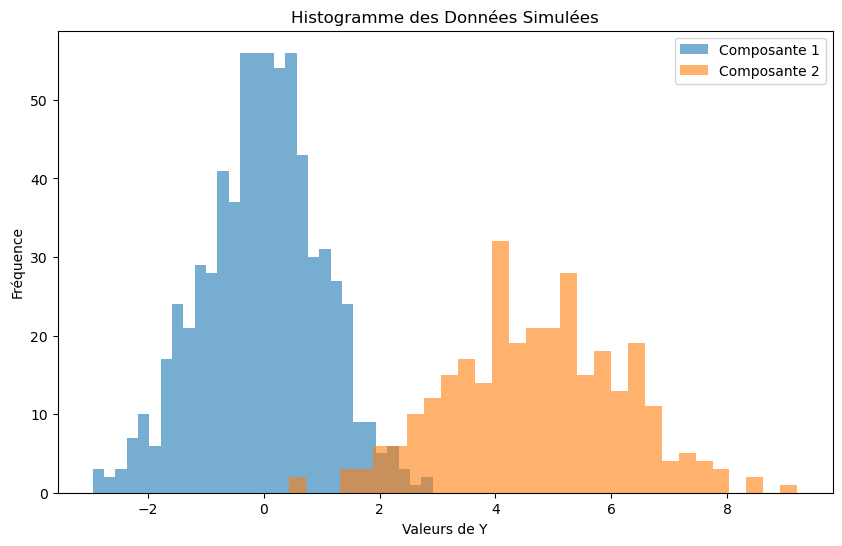

In [38]:
class GaussianMixture:
    def __init__(self, pi, mu1, mu2, sigma1, sigma2):
        self.pi = pi
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma1 = sigma1
        self.sigma2 = sigma2
    
    def sample_z(self, n, rng):
        return rng.binomial(1, self.pi, size=n)
    
    def sample_y(self, z, rng):
        y = np.zeros_like(z, dtype=float)
        n1 = np.sum(z == 1)
        n0 = len(z) - n1
        y[z == 0] = rng.normal(self.mu1, self.sigma1, size=n0)
        y[z == 1] = rng.normal(self.mu2, self.sigma2, size=n1)
        return y

# Paramètres vrais du modèle
pi_true = 0.3
mu1_true = 0.0
mu2_true = 5.0
sigma1_true = 1.0
sigma2_true = 1.5

# Initialisation du vrai modèle
model_true = GaussianMixture(pi=pi_true, mu1=mu1_true, mu2=mu2_true, sigma1=sigma1_true, sigma2=sigma2_true)

# Nombre d'observations
N = 1000

# Simulation des données
z_sim, y_sim = simulate_data(model_true, N, seed=42)

# Visualisation des données simulées
plt.figure(figsize=(10,6))
plt.hist(y_sim[z_sim == 0], bins=30, alpha=0.6, label='Composante 1')
plt.hist(y_sim[z_sim == 1], bins=30, alpha=0.6, label='Composante 2')
plt.legend()
plt.xlabel('Valeurs de Y')
plt.ylabel('Fréquence')
plt.title('Histogramme des Données Simulées')
plt.show()

In [39]:
def log_likelihood(theta, y, z):
    pi, mu1, mu2, sigma1, sigma2 = theta
    # Calculer les log probabilités
    log_pi_z = z * np.log(pi+1e-10) + (1-z) * np.log(1-pi + 1e-10)
    log_p_y_given_z = z * (-0.5*np.log(2 * np.pi * sigma1**2) - 0.5 * ((y-mu1)**2)/sigma1**2) + (1-z) * (-0.5 * np.log(2 * np.pi * sigma2**2) - 0.5 * ((y - mu2)**2) / sigma2**2)
    return np.sum(log_pi_z + log_p_y_given_z)

def compute_grad(theta, y, z):
    pi, mu1, mu2, sigma1, sigma2 = theta
    # Grad pi
    grad_pi = np.sum(z / (pi + 1e-10) - (1 - z) / (1 - pi + 1e-10))
    # Grad mu1
    grad_mu1 = np.sum(z * (y - mu1) / sigma1**2)
    # Grad mu2
    grad_mu2 = np.sum((1 - z) * (y - mu2) / sigma2**2)
    # Grad sigma1
    grad_sigma1 = np.sum(z * (((y - mu1)**2) / sigma1**3 - 1 / sigma1))
    # Grad sigma2
    grad_sigma2 = np.sum((1 - z) * (((y - mu2)**2) / sigma2**3 - 1 / sigma2))
    return np.array([grad_pi, grad_mu1, grad_mu2, grad_sigma1, grad_sigma2])

In [40]:
def sample_z(y, theta, rng):
    pi, mu1, mu2, sigma1, sigma2 = theta
    n = len(y)
    z_new = np.zeros(n, dtype=int)
    
    for i in range(n):
        # Calculer p(z_i=1 | y_i, theta)
        p1 = pi * (1 / (np.sqrt(2 * np.pi) * sigma1)) * np.exp(-0.5 * ((y[i] - mu1)/sigma1)**2)
        p2 = (1 - pi) * (1 / (np.sqrt(2 * np.pi) * sigma2)) * np.exp(-0.5 * ((y[i] - mu2)/sigma2)**2)
        p_z1 = p1 / (p1 + p2 + 1e-10)  # Ajouter epsilon pour éviter division par zéro
        z_new[i] = rng.binomial(1, p_z1)
        
    return z_new


In [51]:
def fisher_sgd_with_preconditioning(y, initial_theta, initial_z, eta=0.01, beta=0.01, lambda_reg=1e-6, K=1000, batch_size=100, seed=42):
    rng = np.random.default_rng(seed)
    theta = initial_theta.copy()
    z = initial_z.copy()
    
    n = len(y)
    indices = np.arange(n)
    
    # Matrice Fisher
    F = lambda_reg * np.eye(len(theta))
    
    thetas_est = []
    
    for epoch in tqdm(range(K), desc="Fisher-SGD"):
        rng.shuffle(indices)
        
        # Mini-batch
        for i in range(0, n, batch_size):
            batch_indices = indices[i:i+batch_size]
            y_batch = y[batch_indices]
            z_batch = z[batch_indices]
            
            # Calcul du gradient
            grad_theta = compute_grad(theta, y_batch, z_batch)
            
            # Mise à jour de la matrice Fisher
            grad_outer = np.outer(grad_theta, grad_theta)
            F = (1 - beta) * F + beta * grad_outer
            
            F_reg = F + lambda_reg * np.eye(len(theta))
            try:
                F_inv = np.linalg.inv(F_reg)
            except np.linalg.LinAlgError:
                print("Matrice Fisher non inversible à l'epoch", epoch)
                F_inv = np.linalg.pinv(F_reg)
            
            # Mise à jour des paramètres
            theta_update = eta * (F_inv @ grad_theta)
            theta = theta + theta_update
        
        # Stocker les estimations pour analyse
        thetas_est.append(theta.copy())
        
        z = sample_z(y, theta, rng)
    
    fisher_info = F / K
    
    return theta, fisher_info, thetas_est


In [52]:
# Initialisation des paramètres
initial_theta = np.array([0.5, 0.5, 4.5, 1.2, 1.2])  # pi, mu1, mu2, sigma1, sigma2
initial_z = sample_z(y_sim, initial_theta, rng=np.random.default_rng(seed=0))  # variables latentes initiales

# Paramètres de l'algorithme
eta = 0.01         # Taux d'apprentissage
beta = 0.01        # Taux de mise à jour de Fisher
lambda_reg = 1e-6  # Régularisation pour l'inversion
K = 3000           # Nombre d'epochs
batch_size = 100   # Taille des mini-batchs
seed = 42          # Graine pour reproductibilité

# Exécution de l'algorithme Fisher-SGD
theta_est, fisher_info, thetas_est = fisher_sgd_with_preconditioning(
    y=y_sim,
    initial_theta=initial_theta,
    initial_z=initial_z,
    eta=eta,
    beta=beta,
    lambda_reg=lambda_reg,
    K=K,
    batch_size=batch_size,
    seed=seed
)

print("Paramètres vrais:")
print(f"pi={pi_true}, mu1={mu1_true}, mu2={mu2_true}, sigma1={sigma1_true}, sigma2={sigma2_true}")

print("\nParamètres initiales:")
print(f"pi={initial_theta[0]}, mu1={initial_theta[1]}, mu2={initial_theta[2]}, sigma1={initial_theta[3]}, sigma2={initial_theta[4]}")

print("\nParamètres estimés:")
print(f"pi={theta_est[0]:.4f}, mu1={theta_est[1]:.4f}, mu2={theta_est[2]:.4f}, "f"sigma1={theta_est[3]:.4f}, sigma2={theta_est[4]:.4f}")

Fisher-SGD: 100%|██████████| 3000/3000 [00:33<00:00, 89.45it/s]

Paramètres vrais:
pi=0.3, mu1=0.0, mu2=5.0, sigma1=1.0, sigma2=1.5

Paramètres initiales:
pi=0.5, mu1=0.5, mu2=4.5, sigma1=1.2, sigma2=1.2

Paramètres estimés:
pi=0.6997, mu1=-0.0188, mu2=4.7443, sigma1=1.0297, sigma2=1.4697


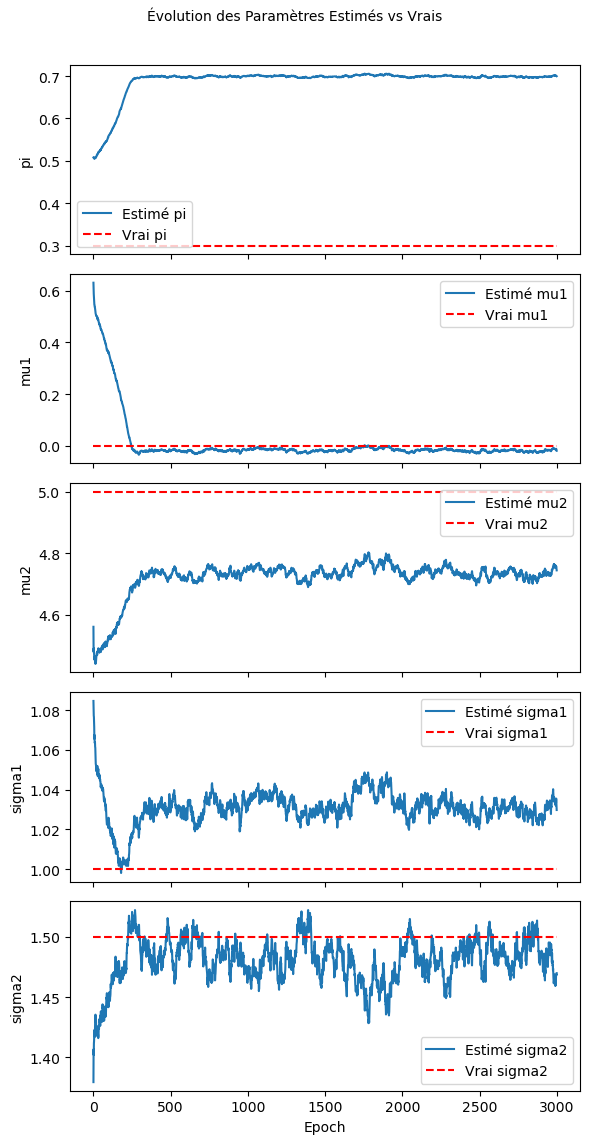

In [56]:
# Labels des paramètres
labels = ['pi', 'mu1', 'mu2', 'sigma1', 'sigma2']

# Créer des sous-graphiques pour chaque paramètre
fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex=True)

for idx, ax in enumerate(axes):
    ax.plot(np.array(thetas_est)[:, idx], label=f'Estimé {labels[idx]}')
    ax.hlines(theta_true[idx], 0, K, colors='r', linestyles='dashed', label=f'Vrai {labels[idx]}')
    ax.set_ylabel(labels[idx])
    ax.legend()

axes[-1].set_xlabel('Epoch')
plt.suptitle('Évolution des Paramètres Estimés vs Vrais', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()